<a href="https://colab.research.google.com/github/EslaM-AhMed14/Computer-Vision/blob/main/EslaM%20AhMed/convolutional_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# convolutional autoencoder Function

In [2]:
def build_autoencoder(input_shape=(28, 28, 1), encoding_size=32, alpha=0.2):
  inputs = keras.layers.Input(shape = input_shape)
  encoder = keras.layers.Conv2D(filters=32,kernel_size= 3 ,activation = "relu",
                                strides=2,padding='same') (inputs)
  encoder = keras.layers.BatchNormalization()(encoder)
  encoder = keras.layers.Conv2D(filters=64,kernel_size= 3,activation = 'relu' ,
                                  strides = 2 , padding = 'same')(encoder)
  encoder = keras.layers.BatchNormalization()(encoder)
  encoder_output_shape = encoder.shape
  encoder = keras.layers.Flatten()(encoder)
  encoder_output = keras.layers.Dense(units=encoding_size)(encoder)

  encoder_model = keras.Model(inputs, encoder_output)


  decoder_input = keras.layers.Input(shape=(encoding_size,))
  target_shape = tuple(encoder_output_shape[1:])
  decoder = keras.layers.Dense(np.prod(target_shape))(decoder_input)
  decoder = keras.layers.Reshape(target_shape)(decoder)
  decoder = keras.layers.Conv2DTranspose(filters=64,kernel_size=3 , activation = 'relu' ,
                              strides=2 , padding = 'same')(decoder)
  decoder = keras.layers.BatchNormalization()(decoder)
  decoder = keras.layers.Conv2DTranspose(filters=32,kernel_size = 3 , activation = "relu",
                              strides = 2 , padding = 'same')(decoder)
  decoder = keras.layers.BatchNormalization()(decoder)

  outputs = keras.layers.Conv2DTranspose(filters=1, kernel_size= 3 , activation = 'sigmoid',
                               padding='same')(decoder)

  decoder_model = keras.Model(decoder_input, outputs)

  encoder_model_output = encoder_model(inputs)
  decoder_model_output = decoder_model(encoder_model_output)
  autoencoder_model = keras.Model(inputs, decoder_model_output)

  return autoencoder_model


# Display Function




In [3]:
def plot_original_vs_generated(original, generated):
  num_images = 15
  sample = np.random.randint(0, len(original), num_images)
  def stack(data):
    images = data[sample]
    return np.vstack([np.hstack(images[:5]),np.hstack(images[5:10]),np.hstack(images[10:15])])
  def add_text(image, text, position):
    pt1 = position
    pt2 = (pt1[0] + 10 + (len(text) * 22),pt1[1] - 45)
    cv2.rectangle(image,pt1,pt2,(255, 255, 255),-1)
    cv2.putText(image, text,position,fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1.3,color=(0, 0, 0),thickness=4)
  original = stack(original)
  generated = stack(generated)
  mosaic = np.vstack([original,generated])
  mosaic = cv2.resize(mosaic, (860, 860),interpolation=cv2.INTER_AREA)
  mosaic = cv2.cvtColor(mosaic, cv2.COLOR_GRAY2BGR)

  add_text(mosaic, 'Original', (50, 100))
  add_text(mosaic, 'Generated', (50, 520))

  return mosaic


## loading Data

In [4]:
(X_train, _), (X_test, _) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


## Normalize and add a channel dimension to the images

In [5]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0



X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Build the autoencoder

In [6]:
autoencoder = build_autoencoder(encoding_size=256)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.fit(X_train, X_train, epochs=50, batch_size=1024,
                shuffle=True, validation_data=(X_test, X_test),verbose=1)




Epoch 1/50
59/59 [==============================] - 160s 3s/step - loss: 0.0437 - val_loss: 0.1111
Epoch 2/50
59/59 [==============================] - 146s 2s/step - loss: 0.0160 - val_loss: 0.1085
Epoch 3/50
59/59 [==============================] - 140s 2s/step - loss: 0.0108 - val_loss: 0.0953
Epoch 4/50
59/59 [==============================] - 143s 2s/step - loss: 0.0084 - val_loss: 0.0737
Epoch 5/50
59/59 [==============================] - 138s 2s/step - loss: 0.0069 - val_loss: 0.0504
Epoch 6/50
59/59 [==============================] - 144s 2s/step - loss: 0.0060 - val_loss: 0.0293
Epoch 7/50
59/59 [==============================] - 139s 2s/step - loss: 0.0053 - val_loss: 0.0183
Epoch 8/50
59/59 [==============================] - 141s 2s/step - loss: 0.0049 - val_loss: 0.0085
Epoch 9/50
59/59 [==============================] - 139s 2s/step - loss: 0.0045 - val_loss: 0.0054
Epoch 10/50
59/59 [==============================] - 139s 2s/step - loss: 0.0041 - val_loss: 0.0046
Epoch 11/

# Make prediction

In [7]:
predictions = autoencoder.predict(X_test)

313/313 [==============================] - 9s 27ms/step


## Reshape the images

In [8]:
original_shape = (X_test.shape[0], 28, 28)
predictions = predictions.reshape(original_shape)
X_test = X_test.reshape(original_shape)
predictions = (predictions * 255.0).astype('uint8')
X_test = (X_test * 255.0).astype('uint8')

# Drow original Vs generated  

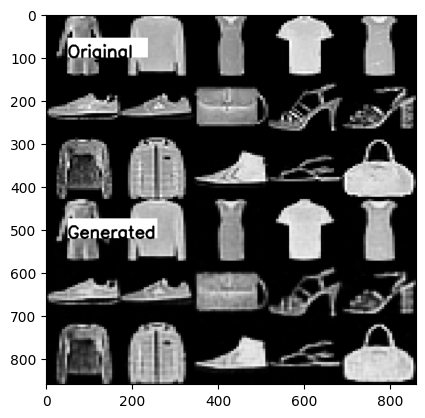

In [9]:
image = plot_original_vs_generated(X_test, predictions)
plt.imshow(image)